## Test Pipeline

In this notebook we demonstrate how to test a given video for real/fake.

Requirements: 

<ul>
    <li> Path to OpenFace2.0 build/bin folder. This folder is created after OpenFace compilation. Please follow the instructions given <a href="https://github.com/TadasBaltrusaitis/OpenFace/wiki">here</a> to compile OpenFace2.0 on your machine.
     <li> Path to the model trained on POI specific videos.
     <li> Path to the POI specific test video. Please see README.md for the specification of this video. 
</ul>

In [1]:
%reload_ext autoreload
%autoreload 2
%pylab inline
import os
import utils as u
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


### 1) Initialize

Initialize the parameter dictionary with the name of the test file and the model file to use. The sample dictionary entries for the five POIs whose model files are kept in models folder. For Obama, we have two models '190_bo_diff.pkl' and '29_bo_diff.pkl' using all pairs of 190 features and 29 selected features. For more details, please refer to the paper.pdf

In [2]:
open_face_path = 'OpenFace' #path to OpenFace build/bin

#OBAMA
bo_dict = {'video_nm': 'test_ex/obama-lipsync.mp4', 'model_file': 'models/29_bo_diff.pkl'}

#BERNIE
bs_dict = {'video_nm': 'test_ex/sanders-real2.mp4', 'model_file': 'models/bs_diff.pkl'}

#TRUMP
dt_dict = {'video_nm': 'trump_spectre/real.mp4', 'model_file': 'models/dt_diff.pkl'}

#HILLARY
hc_dict = {'video_nm': 'test_ex/clinton-faceswap.mp4', 'model_file': 'models/hc_diff.pkl'}

#WARREN
ew_dict = {'video_nm': 'test_ex/warren-faceswap.mp4', 'model_file': 'models/ew_diff.pkl'}

param_dict = bo_dict #select the dictionary
print(' Video: {} \n Model: {}'.format(param_dict['video_nm'], param_dict['model_file']))

 Video: test_ex/obama-lipsync.mp4 
 Model: models/29_bo_diff.pkl


### 2) read the model

read the POI specific model whose path is specified in the above dictionary. This model file has all the hyper-parameters that were used to train the model, which will be used during training as well. 

In [3]:
#read the model
model = u.load_obj(param_dict['model_file'])
model['feat_name'] = [x.replace(' ', '') for x in model['feat_name']]
assert model is not None

print(model.keys())

dict_keys(['scaler', 'model', 'prob_rng', 'clip_len', 'feat_name', 'shift_win', 'c_t'])


### 3) extract the facial features using OpenFace

Run OpenFace to extract the facial features like 17 Action Units, 3-D head rotation, 68 2-D and 3-D facial landmarks. For more details on the features given by OpenFace2.0 see <a href="https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format">here</a>. These features are estimated for every frame in the video. The estimations below the confidence threshold model['c_t'] are rejected. Any video clip that has less confident estimations are not considered here. 

The feature extraction needs the path to build/bin folder created after compilation of OpenFace. 

In [4]:
#get all the facial features from OpenFace
csv_features = u.get_facial_features(param_dict['video_nm'], open_face_path, conf_thres=model['c_t']) # we need less rejection

print(csv_features.head())

   frame  face_id  timestamp  confidence  success  pose_Tx  pose_Ty  pose_Tz  \
0      1        0      0.000        0.98        1     -7.5     27.3    299.4   
1      2        0      0.033        0.98        1     -7.6     27.3    299.9   
2      3        0      0.067        0.98        1     -7.2     27.0    298.3   
3      4        0      0.100        0.98        1     -7.1     26.9    297.6   
4      5        0      0.133        0.93        1     -8.4     27.8    299.0   

   pose_Rx  pose_Ry  ...  AU15_c  AU17_c  AU20_c  AU23_c  AU25_c  AU26_c  \
0    0.055    0.115  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.045    0.109  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.063    0.111  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.064    0.113  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.025    0.122  ...     0.0     0.0     0.0     0.0     0.0     0.0   

   AU28_c  AU45_c   lip_hor   lip_ver  
0     0.0     0.0  0.9

### 4) compute 190-D correlations

compute all pair correlations for all overlapping 10-second clips in the video. The 10-second clips with frames rejected for less confidence are not considered here. 

In [5]:
#get all the 190 correlations from the facial features
corr_ft = u.get_corr_per_frame(csv_features, model['clip_len'], model['shift_win'])

print('Number of clips extracted {}'.format(len(corr_ft)))

Number of clips extracted 274


### 5) predict

Using the model predict the score that the 10-second clips belong to the POI. Higher score means more likely that the clip is of POI.

In [6]:
col_names = model['feat_name'] # get the correlation features to consider
print(col_names)

if len(corr_ft):
    #probability for testing: 10-second clip
    pred_prob = model['model'].score_samples(model['scaler'].transform(np.array(corr_ft[col_names])))
    pred_prob = (pred_prob - model['prob_rng'][0])/model['prob_rng'][1] #normalize
else:
    print('OpenFace feature detection not confident enough to predict')

['AU10_rlip_hor', 'AU15_rlip_hor', 'pose_Rxlip_ver', 'AU14_rpose_Rx', 'AU15_rAU25_r', 'AU20_rAU26_r', 'AU26_rlip_ver', 'AU02_rlip_ver', 'AU10_rAU17_r', 'AU25_rpose_Rx', 'AU12_rAU15_r', 'AU14_rAU20_r', 'AU25_rlip_hor', 'AU04_rpose_Rx', 'AU06_rAU09_r', 'AU20_rAU23_r', 'AU07_rAU23_r', 'pose_Rxpose_Rz', 'AU09_rlip_ver', 'AU02_rpose_Rz', 'AU01_rlip_ver', 'lip_verlip_hor', 'AU15_rlip_ver', 'AU05_rAU25_r', 'AU01_rAU12_r', 'AU26_rlip_hor', 'AU12_rpose_Rx', 'AU10_rAU14_r', 'AU15_rpose_Rx']


In [8]:
model['prob_rng']

[3198.9377566403227, 4661.48675751171]

In [7]:
pred_prob

array([ 0.07916495,  0.08483483,  0.08764394,  0.08945843,  0.08184978,
        0.09532999,  0.05676347,  0.03910726,  0.03157539,  0.01792279,
        0.01824119,  0.01297066, -0.00316742,  0.013532  ,  0.01503606,
        0.03212861,  0.02738381,  0.01988415,  0.01350342,  0.01046001,
       -0.00358163, -0.01645943, -0.03143402, -0.03615651, -0.04048427,
       -0.06210443, -0.07791749, -0.08899369, -0.09284215, -0.10017923,
       -0.10112237, -0.1031763 , -0.07028251, -0.05933699, -0.05452416,
       -0.04212009, -0.02377477, -0.0111796 , -0.01036836, -0.01254998,
       -0.01197558, -0.01121307, -0.01098029, -0.01618526, -0.02435293,
       -0.02523499, -0.0221086 , -0.01437527, -0.00863323, -0.00292357,
       -0.00198632, -0.01821009, -0.01885723, -0.01716019, -0.00062158,
        0.02318668,  0.04372796,  0.0425487 ,  0.02442947,  0.01992694,
        0.01996362,  0.03005928,  0.01924398,  0.01899684, -0.01474981,
       -0.06256589, -0.07475418, -0.10455164, -0.09439283, -0.07

### 6) plot

Plot the histogram of scores computed over all the clips in the video. The clips with scores greater than zero are considered real. The title of the bar shows the proportion of clips classified as real in the video.

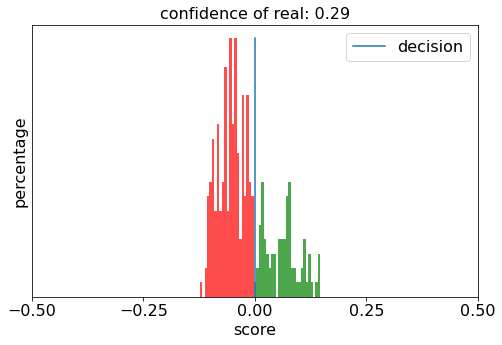

In [26]:
#plot the probability histogram
#zero is considered as the threshold
def plot_bar_graph(pred_prob):
    
    plt.figure(figsize=(8, 5)) #create figure
    
    nn_id = np.logical_not(np.isnan(pred_prob)) #remove nan if any
    pred_prob = pred_prob[nn_id]
    
    #clip the pred_prob between [-1 , 1] for clarity
    pred_prob[pred_prob<-1] = -0.5
    pred_prob[pred_prob>1] = 0.5
    
    bins = np.linspace(np.min(pred_prob), np.max(pred_prob), 50)
    s_counts, s_bin_edges = u.get_bins_edges(pred_prob, bins)
    
    plt.bar(s_bin_edges[s_bin_edges>0], s_counts[s_bin_edges>0], width=s_bin_edges[1] - s_bin_edges[0], color='g', alpha=0.7)
    plt.bar(s_bin_edges[s_bin_edges<0], s_counts[s_bin_edges<0], width=s_bin_edges[1] - s_bin_edges[0], color='r', alpha=0.7)    
    plt.plot([0, 0], [0, np.max(s_counts)], label='decision')
    
    plt.xlabel('score', fontsize=16)
    plt.ylabel('percentage', fontsize=16)
    plt.xlim([-0.5, 0.5])
    plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize=16)
    plt.yticks([], fontsize=16)

    plt.title('confidence of real: {0:.2f}'.format(np.sum(pred_prob>=0)/len(pred_prob)), fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    
#plot the histogram
plot_bar_graph(pred_prob)